In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy import stats
from ephysvibe.trials.spikes import firing_rate,sp_constants
# from ephysvibe.trials import select_trials
from ephysvibe.spike_sorting import config
from ephysvibe.task import def_task,task_constants
from collections import defaultdict
from typing import Dict
from ephysvibe.structures.spike_data import SpikeData
from ephysvibe.structures.bhv_data import BhvData
from ephysvibe.analysis import circular_stats
import os 
seed = 2023

### Def functions

In [2]:
def moving_average(data:np.ndarray,win:int,step:int=1)-> np.ndarray:
    d_shape=data.shape
    count = 0
    if len(d_shape) == 3:
        d_avg = np.zeros((d_shape[0],d_shape[1],int(np.floor(d_shape[2]/step))))
        for i_step in np.arange(0,d_shape[2]-win,step):
            d_avg[:,:,count] = np.mean(data[:,:,i_step:i_step+win],axis=2)
            count +=1
    if len(d_shape) == 2:
        d_avg = np.zeros((d_shape[0],int(np.floor(d_shape[1]/step))))
        for i_step in np.arange(0,d_shape[1]-win,step):
            d_avg[:,count] = np.mean(data[:,i_step:i_step+win],axis=1)
            count +=1
    if len(d_shape) == 1:
        d_avg = np.zeros((int(np.floor(d_shape[0]/step))))
        for i_step in np.arange(0,d_shape[0]-win,step):
            d_avg[count] = np.mean(data[i_step:i_step+win],axis=0)
            count +=1
    return d_avg

In [4]:
def get_task_variables(data:SpikeData,bhv:BhvData,in_out:str='in'):
    # Select trials (correct and DMTS task) and create task frame
    trial_idx = np.where(np.logical_and(data.trial_error == 0, data.block == 1))[0]

    if np.any(np.isnan(data.neuron_cond)):
        neuron_cond = np.ones(len(data.clustersgroup))
    else:
        neuron_cond=data.neuron_cond
    task = def_task.create_task_frame(
        condition=bhv.condition[trial_idx],
        test_stimuli=bhv.test_stimuli[trial_idx],
        samples_cond=task_constants.SAMPLES_COND,
        neuron_cond = neuron_cond,
    )
    task = task[task['in_out']==in_out]
    return task, trial_idx

In [5]:
def get_sp_feature(sp_samples_samp,test_stimuli_samp,code_samples_samp,color_orient,stim_num):
    all_sp_tests=[]
    for i_num,i_stim in enumerate(stim_num):
        i_trial, i_test = np.where(np.char.find(test_stimuli_samp,i_stim)==color_orient)
        tests_on = code_samples_samp[i_trial,2*i_test+6].astype(int)
        sp_stim = sp_samples_samp[i_trial]
        sp_tests = SpikeData.indep_roll(sp_stim, -tests_on, axis=1)[:, 0:550]
        if np.isnan(np.sum(sp_tests)):
            raise ValueError('nan values')
        all_sp_tests.append(sp_tests)
    return all_sp_tests

In [6]:
def delete_match(test_stimuli,code):
    code = (code-1).astype(int)
    tests_shape=test_stimuli.shape
    test_stimuli = np.concatenate([test_stimuli,np.ones((tests_shape[0],1))],axis=1)
    test_stimuli[np.arange(tests_shape[0]),code] =  np.nan
    test_stimuli = test_stimuli[:,:tests_shape[1]]
    return test_stimuli.astype(str)

In [20]:
def select_rand_trials_from_samples(trials_fr,min_n_trials,seed:int=1,n_iterations:int=1000):
    rng = np.random.default_rng(seed=seed)
    it_seed = rng.integers(low=1, high=10000, size=n_iterations, dtype=int)
    stim_num=['1','2','3','4','5','6','7','8']
    stim_angle = np.array([0,45,90,135,180,225,270,315]) * np.pi/180
    mean_select=[]
    for n_it in range(n_iterations):
        np.random.seed(it_seed[n_it]) 
        mean_resp = np.zeros((8,2))
        for i_num,i_stim in enumerate(stim_num):
            fr = np.random.choice(trials_fr[i_num], size=min_n_trials[i_num], replace=True, p=None)
            mean_resp[i_num] = circular_stats.mean_vector(fr, [stim_angle[i_num]]*len(fr))
        mean_select.append(circular_stats.mean_vector(mean_resp[:,0], mean_resp[:,1]) )
    mean_select=np.array(mean_select)
    return mean_select

In [21]:
def get_null_vector_from_samples(trials_fr,min_n_trials,seed:int=1,n_iterations:int=1000):
    rng = np.random.default_rng(seed=seed)
    it_seed = rng.integers(low=1, high=10000, size=n_iterations, dtype=int)
    stim_num=['1','2','3','4','5','6','7','8']
    stim_angle = np.array([0,45,90,135,180,225,270,315]) * np.pi/180
    mean_select=[]

    for n_it in range(n_iterations):
        all_sample1 = []
        
        np.random.seed(it_seed[n_it]) 
        for i_num,i_stim in enumerate(stim_num):
            all_sample1.append(np.random.choice(trials_fr[i_num], size=min_n_trials[i_num], replace=False, p=None))
        all_sample1 = np.concatenate(all_sample1)
       
        mean_resp = np.zeros((8,2))
        for i_num,i_stim in enumerate(stim_num):
            fr = np.random.choice(all_sample1, size=min_n_trials[i_num], replace=True, p=None)

            mean_resp[i_num] = circular_stats.mean_vector(fr, [stim_angle[i_num]]*len(fr))
        mean_select.append(circular_stats.mean_vector(mean_resp[:,0], mean_resp[:,1]) )
    mean_select=np.array(mean_select)
    return mean_select

In [22]:
## Permutation test
def permutation_test(mean_select,mean_null):
    radius = mean_select[:,0]
    angle =  mean_select[:,1]
    X = (np.array(radius) * np.cos(angle))
    Y = (np.array(radius) * np.sin(angle))
    ampl_dir_vector = np.sqrt(X**2+Y**2)
    radius = mean_null[:,0]
    angle =  mean_null[:,1]
    X = (np.array(radius) * np.cos(angle))
    Y = (np.array(radius) * np.sin(angle))
    ampl_null_vector = np.sqrt(X**2+Y**2)
    diff=[]
    for i in range(len(ampl_dir_vector)):
        shift = np.concatenate([ampl_dir_vector[i:],ampl_dir_vector[:i]])
        diff.append(shift-ampl_null_vector)
    diff=np.concatenate(diff)
    p_value = np.sum(diff<0)/len(diff)
    return p_value

In [29]:
def get_trials_by_sample_features(task,test_stimuli,code_samples,sp_samples,stim_num):
    color = 1
    orient = 0
    all_sample_feature = {"o1_c1":{"color":[],"orientation":[]},"o1_c5":{"color":[],"orientation":[]},"o5_c1":{"color":[],"orientation":[]},"o5_c5":{"color":[],"orientation":[]}}
    for i,i_sample in enumerate(["o1_c1","o1_c5","o5_c1","o5_c5"]):
        
        task_sample = task[task['sample']==i_sample]
        trials = task_sample['trial_idx'].values
        test_stimuli_samp = test_stimuli[trials]

        code_samples_samp = code_samples[trials]
        sp_samples_samp = sp_samples[trials]
        code = task_sample['code'].values
        test_stimuli_samp = delete_match(test_stimuli_samp,code)

        color_tests = get_sp_feature(sp_samples_samp,test_stimuli_samp,code_samples_samp,color_orient=color,stim_num=stim_num)
        orient_tests = get_sp_feature(sp_samples_samp,test_stimuli_samp,code_samples_samp,color_orient=orient,stim_num=stim_num)

        all_sample_feature[i_sample]["color"]= color_tests
        all_sample_feature[i_sample]["orientation"]= orient_tests
    return all_sample_feature 

### Read files

In [3]:
file1 = open("/envau/work/invibe/USERS/IBOS/code/flow/paths_bhv_lip.txt", "r")
lines_bhv = file1.readlines()
file1 = open("/envau/work/invibe/USERS/IBOS/code/flow/paths_sp_lip.txt", "r")
lines_sp = file1.readlines()
# load all  files
paths_bhv,paths_sp=[],[]
for line in lines_bhv:
    paths_bhv.append(line.strip())
for line in lines_sp:
    paths_sp.append(line.strip())

In [17]:
orient = 0 
color = 1
stim_num=['1','2','3','4','5','6','7','8']
sample=["o1_c1","o5_c1","o1_c5","o5_c5"]
palette = plt.get_cmap('hsv',64)
len_t = 450

/tmp/ipykernel_136147/3123404539.py:7: RuntimeWarning: invalid value encountered in cast
  return test_stimuli.astype(str)
/tmp/ipykernel_136147/792806945.py:83: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,ax = plt.subplots(figsize=(10,3))


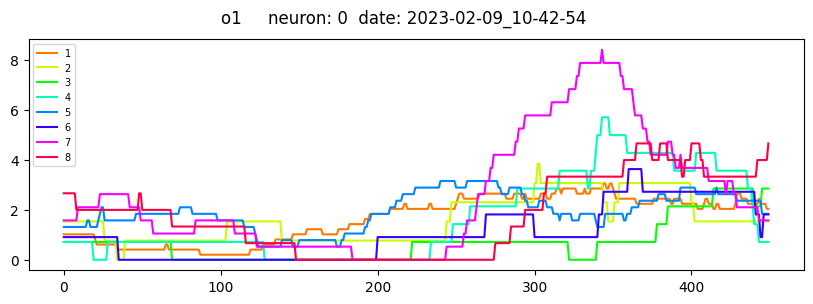

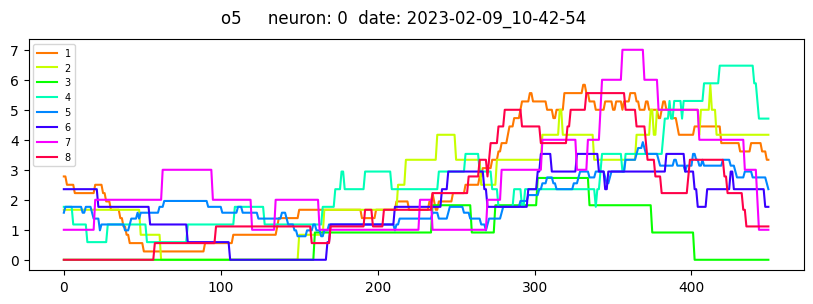

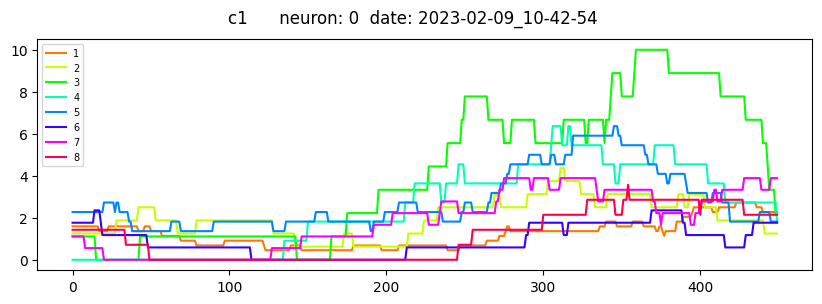

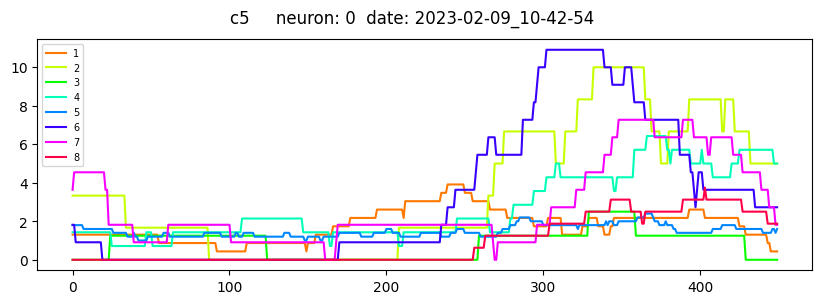

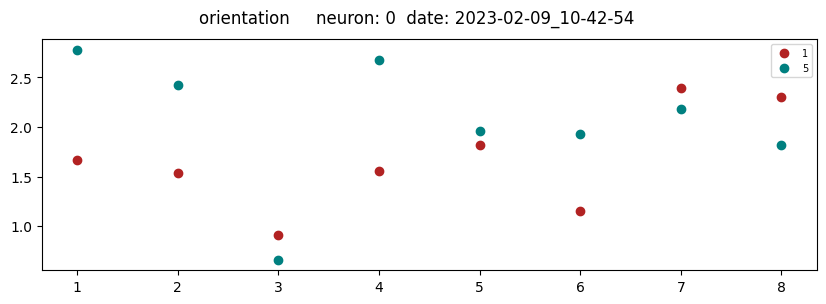

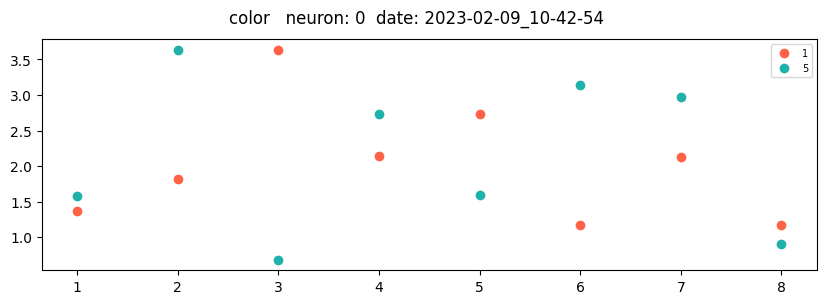

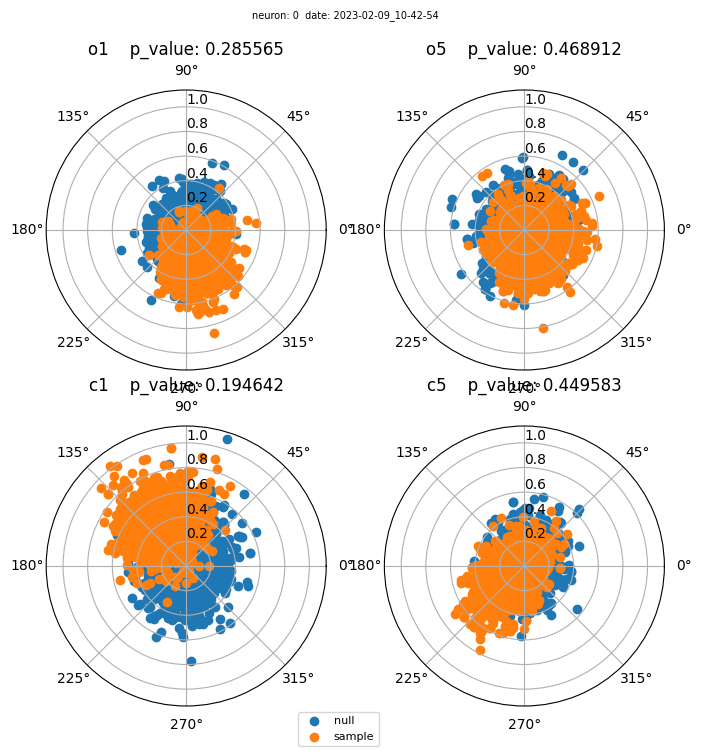

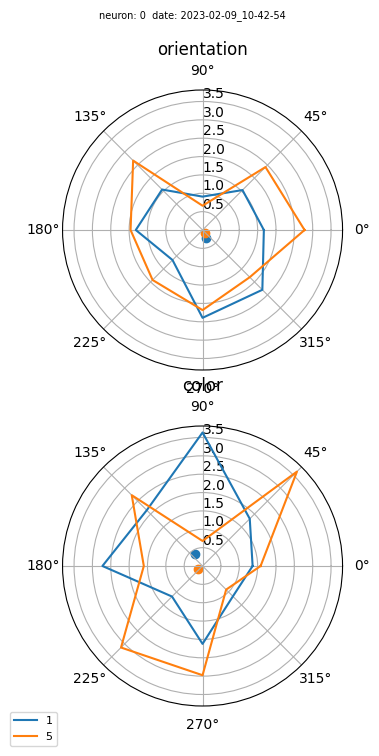

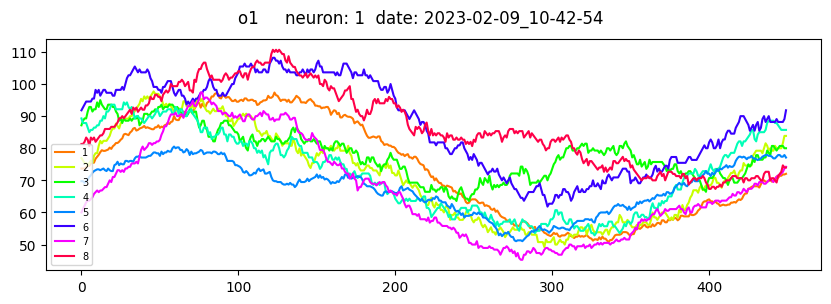

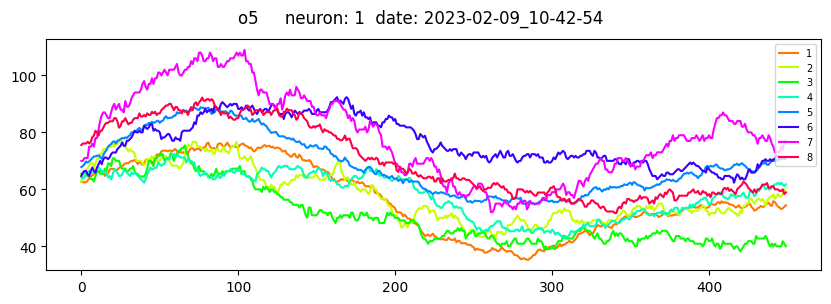

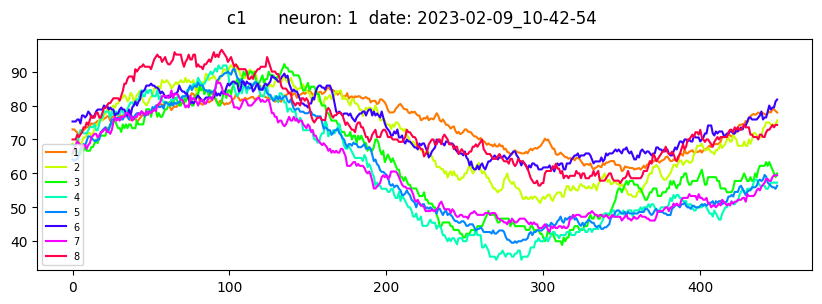

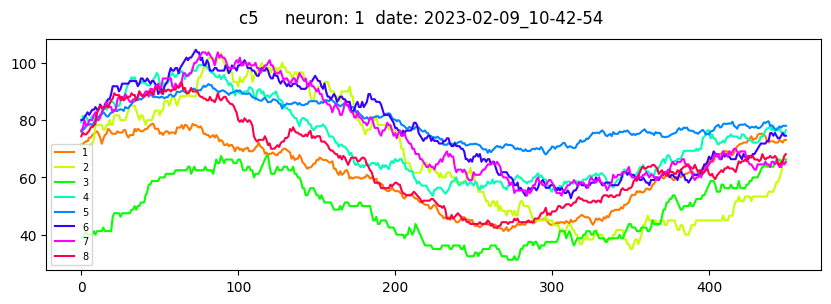

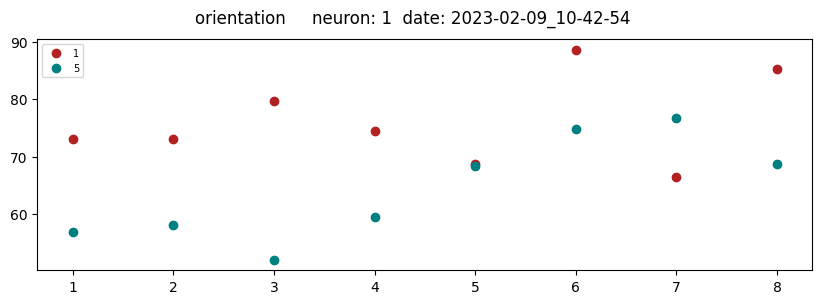

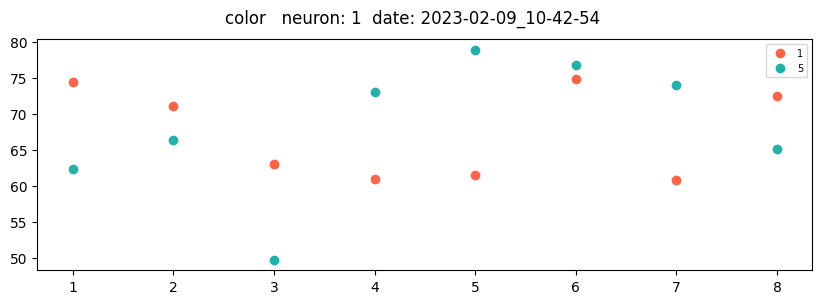

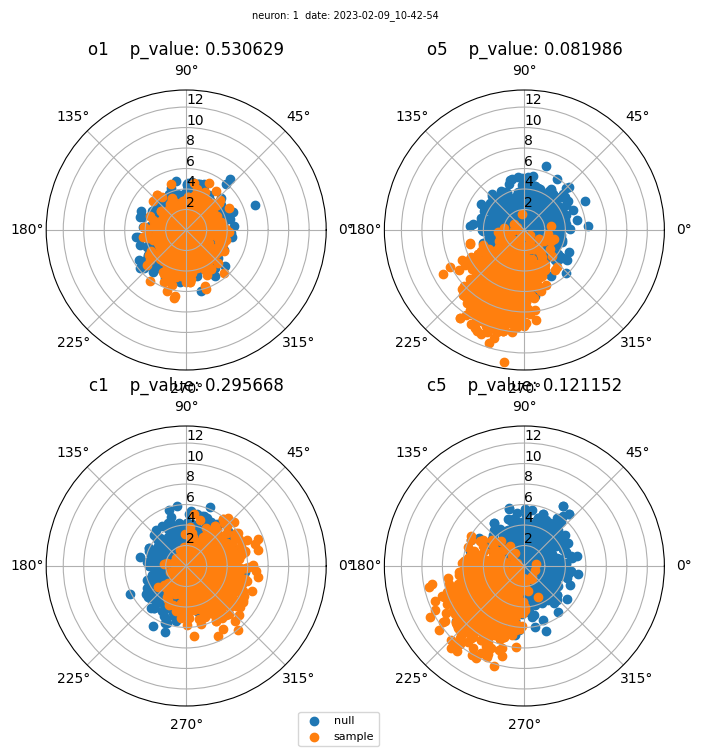

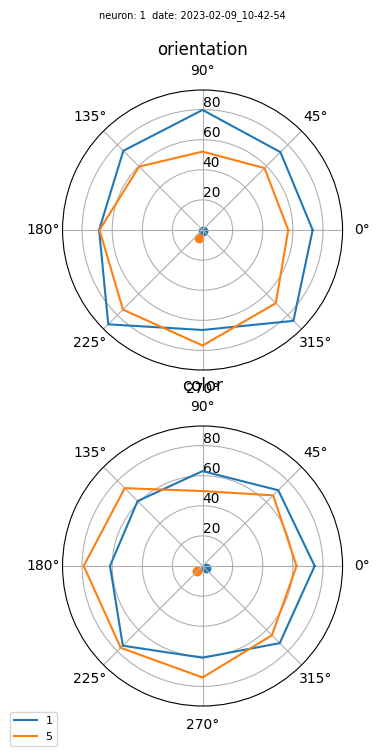

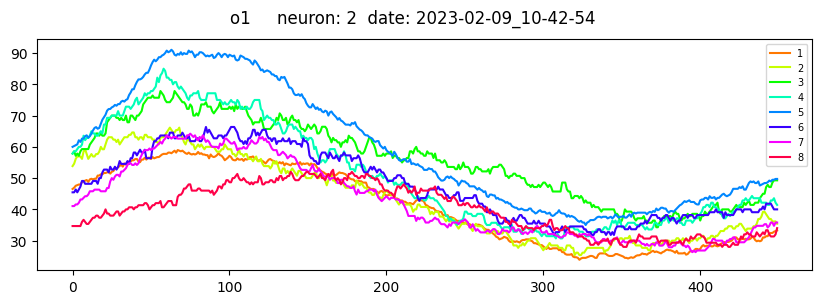

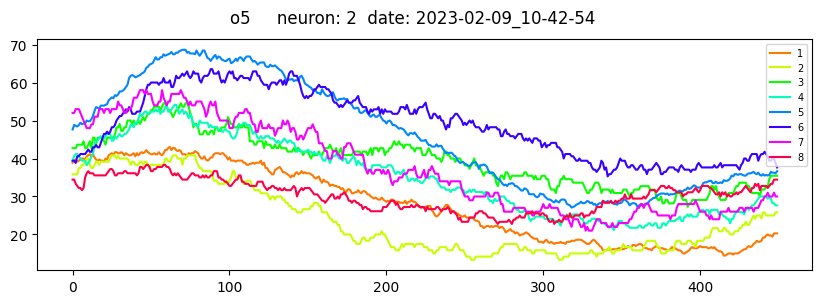

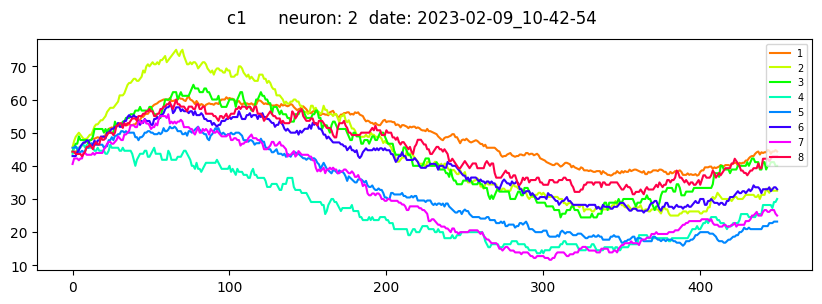

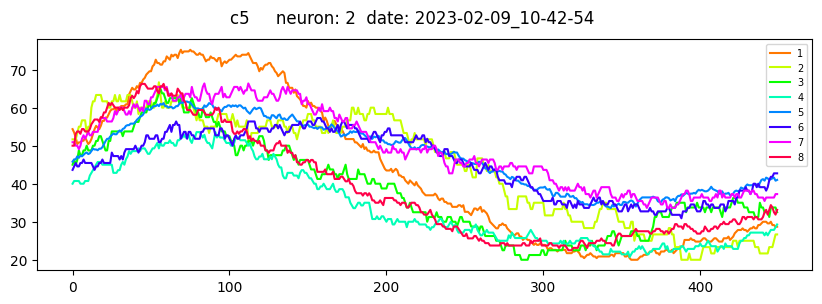

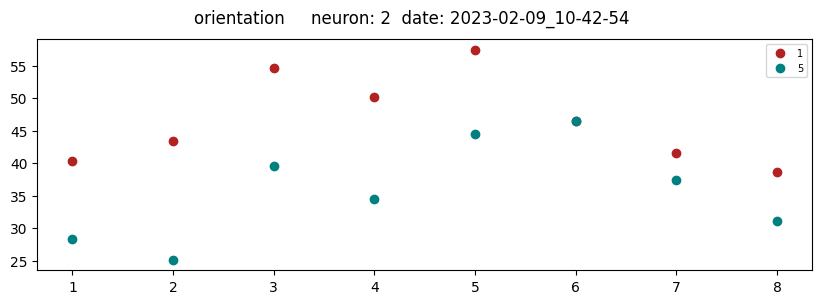

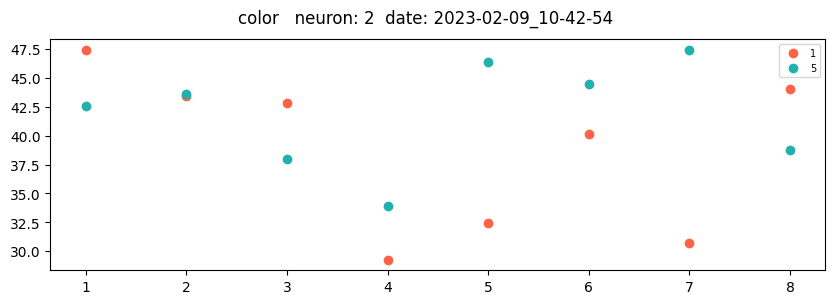

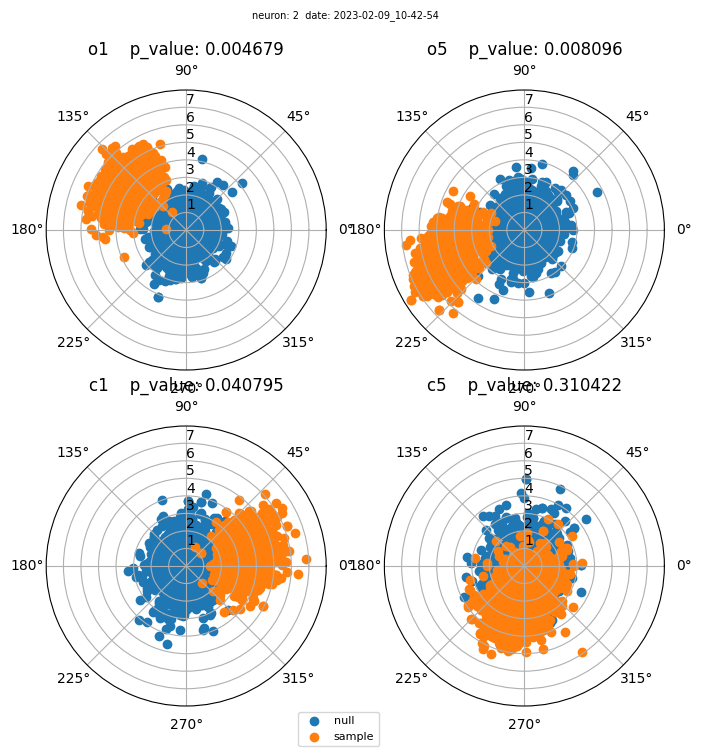

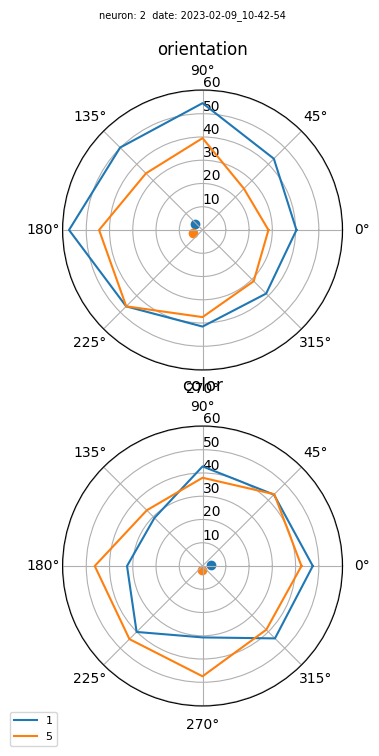

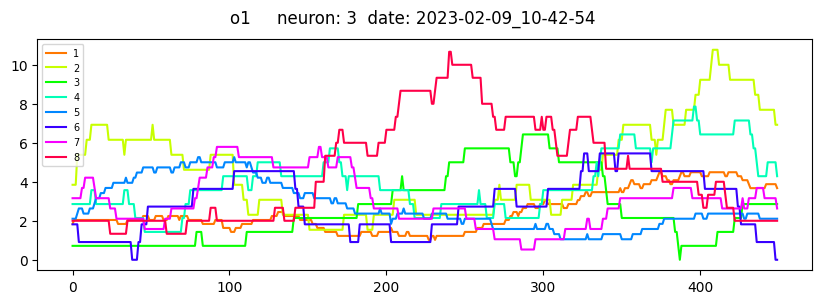

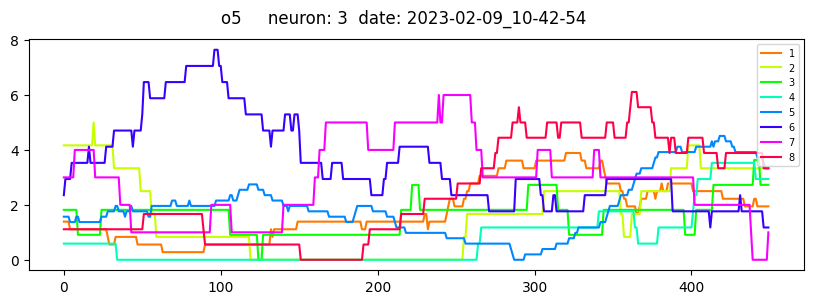

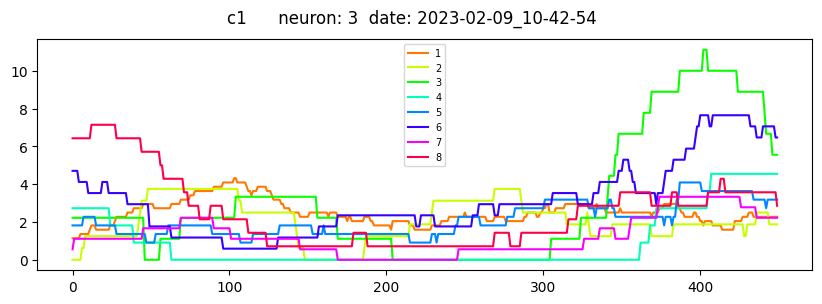

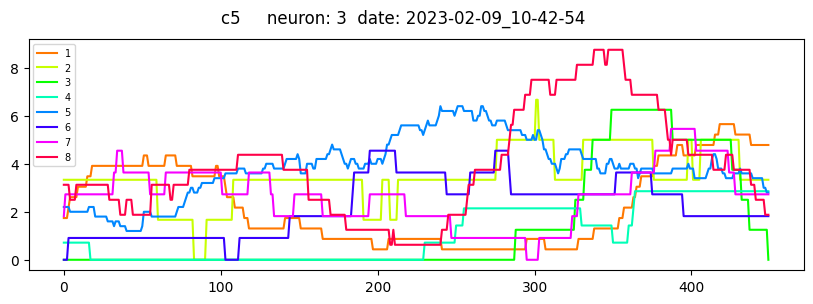

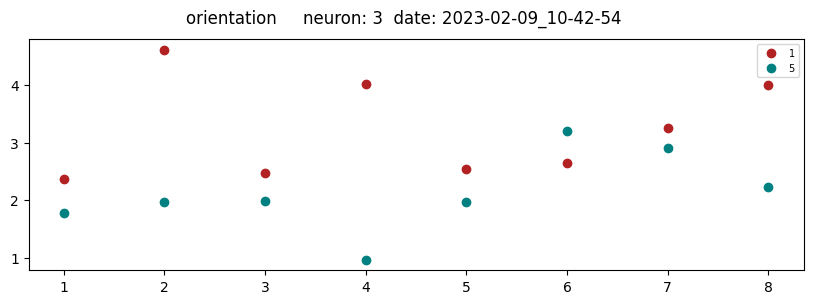

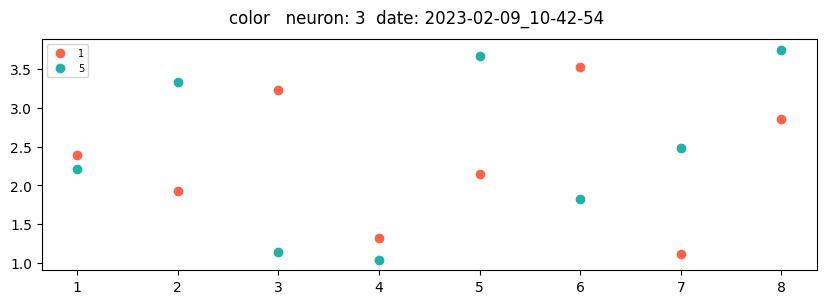

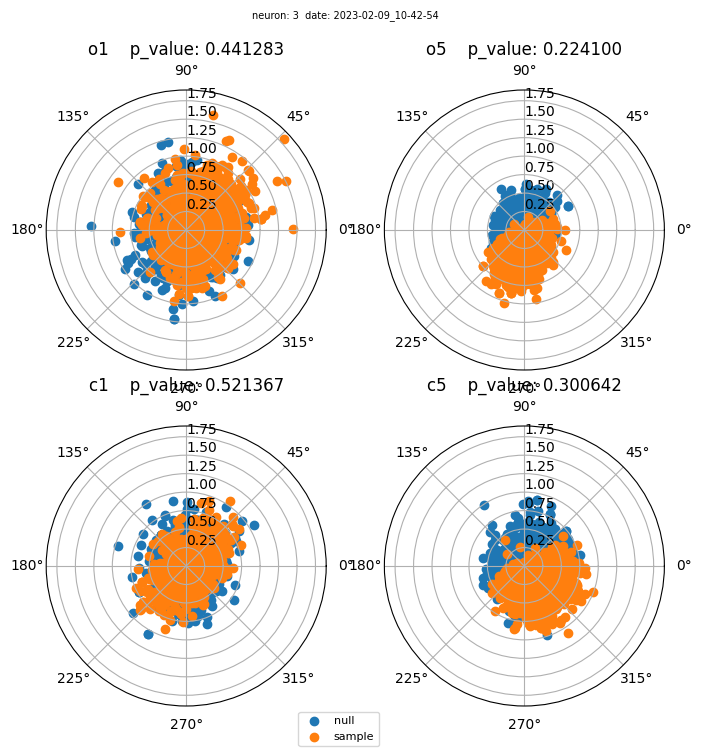

In [26]:
for n_bhv,n_sp in zip(paths_bhv[16:17],paths_sp[16:17]):
    s_path = os.path.normpath(n_sp).split(os.sep)
    date = s_path[-1][:19]
    data = SpikeData.from_python_hdf5(n_sp)
    bhv = BhvData.from_python_hdf5(n_bhv)
    all_task, all_trial_idx = get_task_variables(data,bhv,in_out='in')

    for i_neuron in range(len(data.clustersgroup)):

        task_tr = np.unique(all_task['trial_idx'].values)
        trial_idx = task_tr[np.nansum(data.sp_samples[all_trial_idx[task_tr],i_neuron],axis=1)>0]
        task = all_task[np.in1d(all_task['trial_idx'] , trial_idx)]
        task=task[task['i_neuron']==i_neuron]

        test_stimuli = bhv.test_stimuli[all_trial_idx]
        code_numbers = data.code_numbers[all_trial_idx]
        code_samples = data.code_samples[all_trial_idx]
        sp_samples = data.sp_samples[all_trial_idx,i_neuron]

        len_t1_on=450
        win=100        
        all_sp_test1 = np.zeros((4,len_t1_on+win))

        all_sample_feature = get_trials_by_sample_features(task,test_stimuli,code_samples,sp_samples,stim_num)
        # Select trials for each feature
        o1,o5,c1,c5 = [],[],[],[]
        for i in range(8):
            o1.append(np.concatenate([all_sample_feature["o1_c1"]['orientation'][i],all_sample_feature["o1_c5"]['orientation'][i]],axis=0))
            o5.append(np.concatenate([all_sample_feature["o5_c1"]['orientation'][i],all_sample_feature["o5_c5"]['orientation'][i]],axis=0))
            c1.append(np.concatenate([all_sample_feature["o1_c1"]['color'][i],all_sample_feature["o5_c1"]['color'][i]],axis=0))
            c5.append(np.concatenate([all_sample_feature["o1_c5"]['color'][i],all_sample_feature["o5_c5"]['color'][i]],axis=0))

        fig,ax = plt.subplots(figsize=(10,3))
        for i, o_i in enumerate(o1):
            o_i = o_i.mean(axis=0)
            sample_avg = moving_average(data=o_i,win=win,step=1)*1000
            ax.plot(sample_avg[:len_t],label=stim_num[i],color=palette(i*8+5))
            fig.suptitle('o1     neuron: %d  date: %s'%(i_neuron,date))
            plt.legend( prop={'size': 7})
        fig,ax = plt.subplots(figsize=(10,3))
        for i, o_i in enumerate(o5):
            o_i = o_i.mean(axis=0)
            sample_avg = moving_average(data=o_i,win=win,step=1)*1000
            ax.plot(sample_avg[:len_t],label=stim_num[i],color=palette(i*8+5))
            fig.suptitle('o5     neuron: %d  date: %s'%(i_neuron,date))
            plt.legend( prop={'size': 7})
        fig,ax = plt.subplots(figsize=(10,3))
        for i, o_i in enumerate(c1):
            o_i = o_i.mean(axis=0)
            sample_avg = moving_average(data=o_i,win=win,step=1)*1000
            ax.plot(sample_avg[:len_t],label=stim_num[i],color=palette(i*8+5))
            fig.suptitle('c1      neuron: %d  date: %s'%(i_neuron,date))
            plt.legend( prop={'size': 7})
        fig,ax = plt.subplots(figsize=(10,3))
        for i, o_i in enumerate(c5):
            o_i = o_i.mean(axis=0)
            sample_avg = moving_average(data=o_i,win=win,step=1)*1000
            ax.plot(sample_avg[:len_t],label=stim_num[i],color=palette(i*8+5))
            fig.suptitle('c5     neuron: %d  date: %s'%(i_neuron,date))
            plt.legend( prop={'size': 7})
        
        
        fig,ax = plt.subplots(figsize=(10,3))
        o1_i_all=[]
        o5_i_all=[]
        for i, (o1_i,o5_i) in enumerate(zip(o1,o5)):
            o1_i_all.append(o1_i.mean()*1000)
            o5_i_all.append(o5_i.mean()*1000)
            
        ax.scatter(range(1,9),o1_i_all,color=task_constants.PALETTE_B1[sample[0]],label='1')
        ax.scatter(range(1,9),o5_i_all,color=task_constants.PALETTE_B1[sample[2]],label='5')
        fig.suptitle('orientation     neuron: %d  date: %s'%(i_neuron,date))
        ax.legend( prop={'size': 7})

        fig,ax = plt.subplots(figsize=(10,3))
        c1_i_all=[]
        c5_i_all=[]
        for i, (c1_i,c5_i) in enumerate(zip(c1,c5)):
            c1_i_all.append(c1_i.mean()*1000)
            c5_i_all.append(c5_i.mean()*1000)
            
        ax.scatter(range(1,9),c1_i_all,color=task_constants.PALETTE_B1[sample[1]],label='1')
        ax.scatter(range(1,9),c5_i_all,color=task_constants.PALETTE_B1[sample[3]],label='5')
        fig.suptitle('color   neuron: %d  date: %s'%(i_neuron,date))
        ax.legend( prop={'size': 7})

        o1_trial_avg,o5_trial_avg,c1_trial_avg,c5_trial_avg=[],[],[],[]
        n_trials=[]
        for i in range(8):
            n_tr=[]
            avg = o1[i].mean(axis=1)*1000
            o1_trial_avg.append(avg)
            n_tr.append(len(avg))
            avg = o5[i].mean(axis=1)*1000
            o5_trial_avg.append(avg)
            n_tr.append(len(avg))
            avg = c1[i].mean(axis=1)*1000
            c1_trial_avg.append(avg)
            n_tr.append(len(avg))
            avg = c5[i].mean(axis=1)*1000
            c5_trial_avg.append(avg)
            n_tr.append(len(avg))
            n_trials.append(n_tr)
            
        min_n_trials = np.min(n_trials,axis=1).astype(int)
        all_select = []
        all_null=[]
        all_p_value=[]
        for trial_avg,feature in zip([o1_trial_avg,o5_trial_avg,c1_trial_avg,c5_trial_avg],['o1','o5','c1','c5']):

            if np.sum(min_n_trials<3)>0:
                p_value = np.nan
                mean_null = np.zeros((2,2))
                mean_select = np.zeros((2,2))
            else:
                mean_select = select_rand_trials_from_samples(trial_avg,min_n_trials,seed,n_iterations=1000)
                mean_null = get_null_vector_from_samples(trial_avg,min_n_trials,seed,n_iterations=1000)
                p_value = permutation_test(mean_select,mean_null)

            all_select.append(mean_select)
            all_null.append(mean_null)
            all_p_value.append(p_value)

        fig,((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(8,8),sharex=True,sharey=True,subplot_kw={'projection': 'polar'})
        for i,(ax, feature)in enumerate(zip([ax1,ax2,ax3,ax4],['o1','o5','c1','c5'])):
            ax.set_rlabel_position(90)
            ax.scatter(all_null[i][:,1],all_null[i][:,0],label='null')
            ax.scatter(all_select[i][:,1],all_select[i][:,0],label='sample')
            ax.set_title('%s    p_value: %f'%(feature,all_p_value[i]) )
        fig.suptitle('neuron: %d  date: %s'%(i_neuron,date),fontsize=7)

        plt.legend(loc='upper right', bbox_to_anchor=(0, 0), prop={'size': 8})

        stim_angle = np.array([0,45,90,135,180,225,270,315]) * np.pi/180
        min_n_trials = np.min(n_trials,axis=1).astype(int)
        dir_vector = []
        all_mean_resp=[]
        for trial_avg,feature in zip([o1_trial_avg,o5_trial_avg,c1_trial_avg,c5_trial_avg],['o1','o5','c1','c5']):
            if np.sum(min_n_trials<3)>0:
                p_value = np.nan
                mean_null = np.zeros((2,2))
                mean_select = np.zeros((2,2))
            else:
                mean_select=[]
                mean_resp = np.zeros((8,3))
                for i_num in range(8):
                    fr = trial_avg[i_num]
                    mean_resp[i_num] = [np.mean(fr),np.std(fr),stim_angle[i_num]]
            dir_vector.append(circular_stats.mean_vector(mean_resp[:,0], mean_resp[:,2]))
            all_mean_resp.append(mean_resp)
        fig,(ax1,ax2) = plt.subplots(2,1,figsize=(8,8),sharex=True,sharey=True,subplot_kw={'projection': 'polar'})
        for i,(ax, feature)in enumerate(zip([ax1,ax1,ax2,ax2],['o1','o5','c1','c5'])):
            ax.set_rlabel_position(90)
            mean_angle = np.concatenate([all_mean_resp[i][:,2],[all_mean_resp[i][0,2]]])
            mean_fr = np.concatenate([all_mean_resp[i][:,0],[all_mean_resp[i][0,0]]])
            ax.plot(mean_angle, mean_fr ,label=['1','5','1','5'][i])
            ax.scatter(dir_vector[i][1],dir_vector[i][0])
            title = 'color'
            if feature in ['o1','o5']:
                title = 'orientation'
            #ax.plot(all_mean_resp[i][:,2],all_mean_resp[i][:,0]+all_mean_resp[i][:,1],label='std')
            ax.set_title(title)
        fig.suptitle('neuron: %d  date: %s'%(i_neuron,date),fontsize=7)

        plt.legend(loc='upper right', bbox_to_anchor=(0, 0), prop={'size': 8})

plt.close()